In [1]:
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sys
import matplotlib.pyplot as plt
import torch.nn as nn


sys.path.append('..')
from utils.utils import process_multiple_markets
from utils.data_utils import DataPreprocessor
from models.transformer import TransformerModel

# Data Loading

In [ ]:
data_preprocessor = DataPreprocessor()
df_per_match = data_preprocessor.extract_match_data()

X_train, y_train, X_val, y_val, X_test, y_test = process_multiple_markets(df_per_match)
print(X_train.shape, y_train.shape)

In [ ]:
# np.save('X_train.npy', X_train)
# np.save('y_train.npy', y_train)
# np.save('X_val.npy', X_val)
# np.save('y_val.npy', y_val)
# np.save('X_test.npy', X_test)
# np.save('y_test.npy', y_test)

In [4]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Pre-processing Steps

In [5]:
def normalize_data(X_train, X_val, X_test):
    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit the scaler on the training data (only on the features, not the labels)
    scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

    # Transform the training, validation, and test data
    X_train_normalized = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_normalized = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test_normalized = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    return X_train_normalized, X_val_normalized, X_test_normalized

X_train_normalized, X_val_normalized, X_test_normalized = normalize_data(X_train, X_val, X_test)

In [6]:
def prepare_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64):

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = prepare_data_loaders(X_train_normalized, y_train, X_val_normalized, y_val, X_test_normalized, y_test)
X_item, y_item = next(iter(train_loader))
X_item.shape, y_item.shape

(torch.Size([64, 10, 15]), torch.Size([64, 3]))

# Model Training

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Initialize the tqdm progress bar
    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    # Lists to store average losses for each epoch
    train_losses = []
    val_losses = []
    
    for epoch in pbar:
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        for i, (sequences, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for sequences, labels in val_loader:
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Update tqdm progress bar with the average loss
        pbar.set_postfix({'Epoch Train Loss': f'{avg_train_loss:.4f}', 'Epoch Val Loss': f'{avg_val_loss:.4f}'})

    return train_losses, val_losses

In [8]:
# Instantiate the Transformer model
transformer_model = TransformerModel(input_dim=15,  # Input feature size
                                     d_model=64,   # Embedding size
                                     nhead=4,      # Number of attention heads
                                     num_encoder_layers=2, 
                                     num_decoder_layers=2, 
                                     output_dim=3,  # Output feature size
                                     dropout=0.1)

# Define the criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)
num_epochs = 100
train_losses, val_losses = train_model(transformer_model, train_loader, val_loader, criterion, optimizer, num_epochs)


/usr/local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Training: 100%|██████████| 100/100 [1:19:54<00:00, 47.95s/epoch, Epoch Train Loss=0.0009, Epoch Val Loss=0.0019]


# Model Evaluation and Plotting

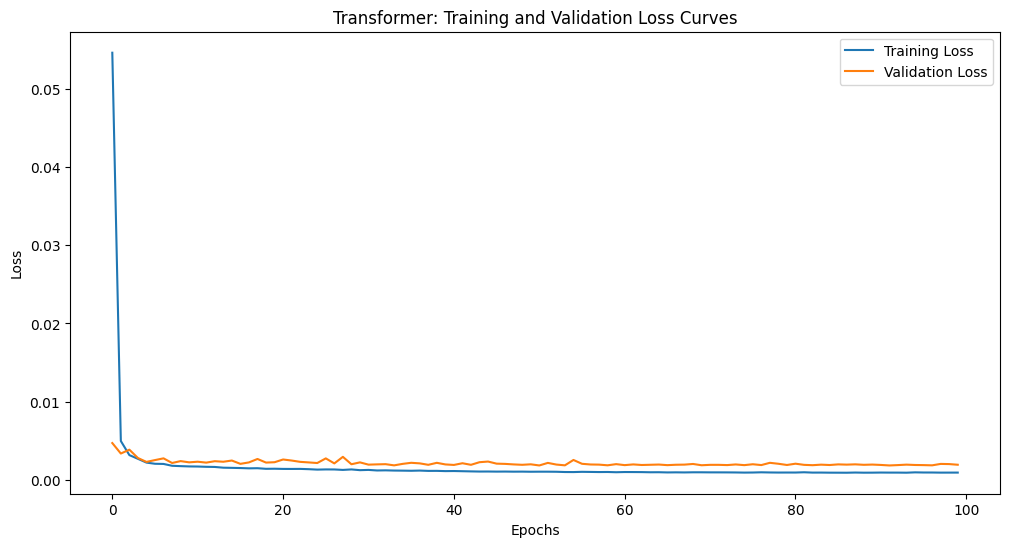

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss') 
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Transformer: Training and Validation Loss Curves')
plt.legend()
plt.show()

In [10]:
transformer_model.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():
    for sequences, labels in test_loader:
        outputs = transformer_model(sequences)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 0.0084


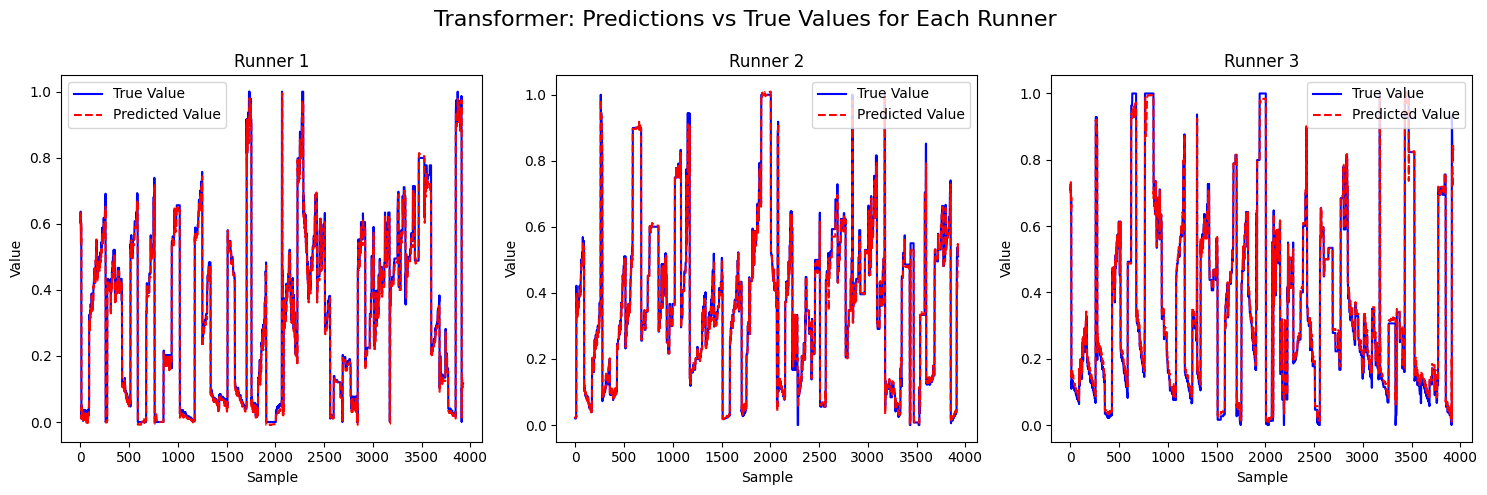

In [18]:
def evaluate_model(model, loader):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for sequences, _ in loader:
            outputs = model(sequences)
            all_predictions.extend(outputs.numpy())
    return np.array(all_predictions)

def plot_predictions(true_values, predictions):
    num_samples, num_selections = true_values.shape

    # Create a subplot for each selection
    fig, axes = plt.subplots(nrows=1, ncols=num_selections, figsize=(15, 5), sharey=False)
    fig.suptitle("Transformer: Predictions vs True Values for Each Runner", fontsize=16)

    # If only one selection, axes might not be iterable, so we force it into a list
    if num_selections == 1:
        axes = [axes]
    
    # Plot true vs predicted values for each selection
    for i in range(num_selections):
        axes[i].plot(true_values[:, i], color='blue', label='True Value')
        axes[i].plot(predictions[:, i], color='red', linestyle='--', label='Predicted Value')
        axes[i].set_title(f'Runner {i+1}')
        axes[i].legend()
        axes[i].set_xlabel('Sample')
        axes[i].set_ylabel('Value')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

predictions = evaluate_model(transformer_model, val_loader)
plot_predictions(torch.tensor(y_val, dtype=torch.float32), predictions)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

y_test_pred = []
y_test_true = []

with torch.no_grad():
    for sequences, labels in test_loader:
        outputs = transformer_model(sequences)
        y_test_pred.extend(outputs.numpy())
        y_test_true.extend(labels.numpy())

y_test_pred = np.array(y_test_pred)
y_test_true = np.array(y_test_true)

rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae = mean_absolute_error(y_test_true, y_test_pred)
r2 = r2_score(y_test_true, y_test_pred)
explained_variance = explained_variance_score(y_test_true, y_test_pred)

print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared: {r2:.4f}')
print(f'Explained Variance Score: {explained_variance:.4f}')


RMSE: 0.0913
MAE: 0.0436
R-squared: 0.9321
Explained Variance Score: 0.9376


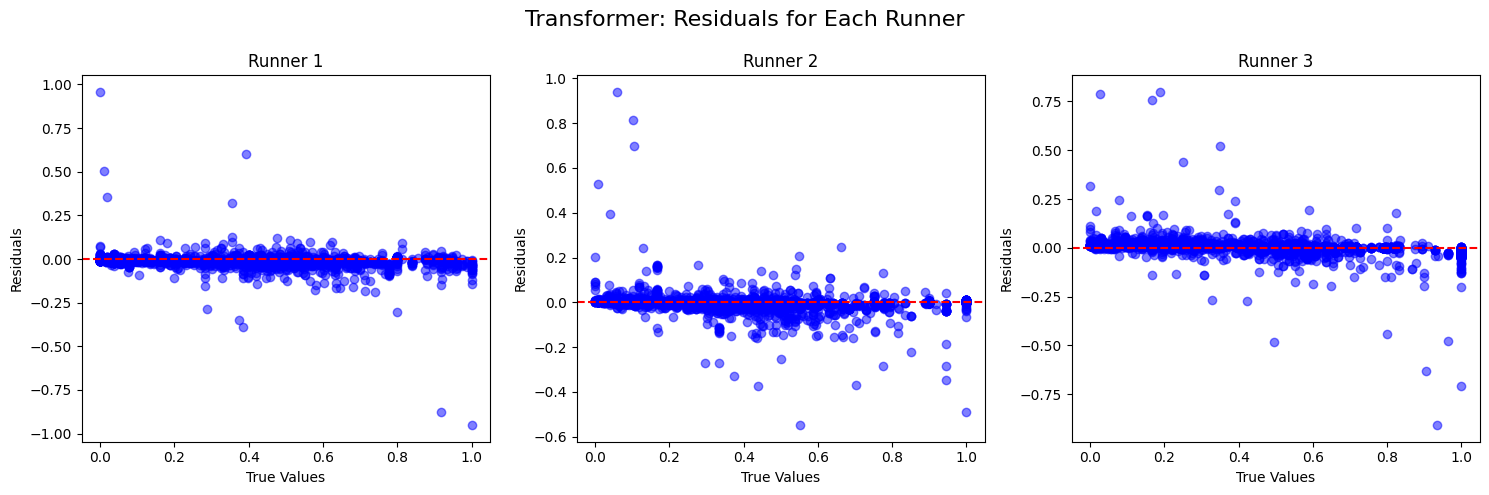

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_residuals(true_values, predictions):
    """
    Plot residuals for each selection in a grid using a similar format to the predictions plot.
    """
    num_samples, num_selections = true_values.shape
    residuals = predictions - true_values

    # Create a subplot for each selection
    fig, axes = plt.subplots(nrows=1, ncols=num_selections, figsize=(15, 5), sharey=False)
    fig.suptitle("Transformer: Residuals for Each Runner", fontsize=16)

    # If only one selection, axes might not be iterable, so we force it into a list
    if num_selections == 1:
        axes = [axes]
    
    # Plot residuals for each selection
    for i in range(num_selections):
        axes[i].scatter(true_values[:, i], residuals[:, i], alpha=0.5, color='blue')
        axes[i].axhline(y=0, color='red', linestyle='--')
        axes[i].set_title(f'Runner {i+1}')
        axes[i].set_xlabel('True Values')
        axes[i].set_ylabel('Residuals')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

plot_residuals(torch.tensor(y_val, dtype=torch.float32).numpy(), predictions)